In [1]:
from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [2]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403210114 ##############################


In [3]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
tr_batch = 6
vl_batch = 1

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([6, 256, 256, 3])


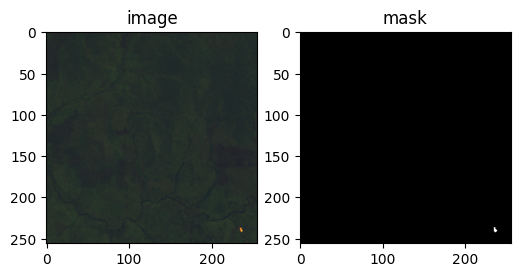

torch.Size([1, 256, 256, 3])


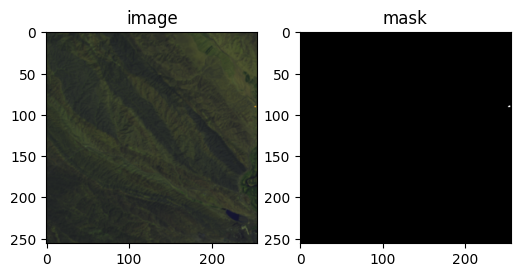

In [4]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [5]:
import sys 
sys.path.append('../')
from network.models import get_pretrained_model
from torchsummary import summary

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
"""model = get_pretrained_model('unet').get()"""
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
# model = get_pretrained_model('attunet').get()
model = get_pretrained_model('r2attunet').get()
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################


model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCELoss()

print(f'device : {device}')
# summary(model, input_size=(3, 224, 224))



Model name : r2attunet
device : cuda


In [6]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [7]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [8]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images)
        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses > best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

  0%|          | 0/4477 [00:00<?, ?it/s]0 [00:00<?, ?it/s]


Epoch : 0/200 | Train Loss : 0.0001592857379159252
Epoch : 0/200 | Train IOU : 3.7373244755763895e-08


Training Progress:   0%|          | 1/200 [00:00<03:13,  1.03it/s]

Epoch : 0/200 | Valid Loss : 0.0001061145529672448
Epoch : 0/200 | Valid IOU : 1.136171933172003e-08
zero-size array to reduction operation maximum which has no identity


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 1/200 | Train Loss : 0.0001495572001321097
Epoch : 1/200 | Train IOU : 4.500425024936215e-08


Training Progress:   1%|          | 2/200 [00:01<02:14,  1.47it/s]

Epoch : 1/200 | Valid Loss : 0.00010486859842103005
Epoch : 1/200 | Valid IOU : 1.136171933172003e-08


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 2/200 | Train Loss : 0.0001412556989932662
Epoch : 2/200 | Train IOU : 6.903718517515338e-08


Training Progress:   2%|▏         | 3/200 [00:01<01:54,  1.72it/s]

Epoch : 2/200 | Valid Loss : 0.00010347042346479994
Epoch : 2/200 | Valid IOU : 1.1633491247257166e-08


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 3/200 | Train Loss : 0.00013238712163383682
Epoch : 3/200 | Train IOU : 1.3470144637439943e-07


Training Progress:   2%|▏         | 4/200 [00:02<01:44,  1.87it/s]

Epoch : 3/200 | Valid Loss : 0.00010188027095723668
Epoch : 3/200 | Valid IOU : 3.929296286042669e-14


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 4/200 | Train Loss : 0.0001240450408753205
Epoch : 4/200 | Train IOU : 2.7949828800144326e-07


Training Progress:   2%|▎         | 5/200 [00:02<01:40,  1.94it/s]

Epoch : 4/200 | Valid Loss : 0.00010059838497363536
Epoch : 4/200 | Valid IOU : 5.683981869604834e-14


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 5/200 | Train Loss : 0.00011673040466700543
Epoch : 5/200 | Train IOU : 5.222849509586627e-07


Training Progress:   3%|▎         | 6/200 [00:03<01:37,  1.99it/s]

Epoch : 5/200 | Valid Loss : 0.00010012152118640255
Epoch : 5/200 | Valid IOU : 5.6196352279140126e-14


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 6/200 | Train Loss : 0.0001102386906606586
Epoch : 6/200 | Train IOU : 1.112646836207492e-06


Training Progress:   4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Epoch : 6/200 | Valid Loss : 9.926173195231786e-05
Epoch : 6/200 | Valid IOU : 7.057835742167145e-14


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 7/200 | Train Loss : 0.00010436423154502461
Epoch : 7/200 | Train IOU : 1.5770767266020223e-06


Training Progress:   4%|▍         | 8/200 [00:04<01:31,  2.10it/s]

Epoch : 7/200 | Valid Loss : 9.772561862232608e-05
Epoch : 7/200 | Valid IOU : 1.0637166666646633e-12


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 8/200 | Train Loss : 0.00010016450717935399
Epoch : 8/200 | Train IOU : 2.201834411886832e-06


Training Progress:   4%|▍         | 9/200 [00:04<01:29,  2.13it/s]

Epoch : 8/200 | Valid Loss : 9.513756098005192e-05
Epoch : 8/200 | Valid IOU : 1.861504117062728e-12


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 9/200 | Train Loss : 9.8063812901299e-05
Epoch : 9/200 | Train IOU : 2.7202634335975443e-06


Training Progress:   5%|▌         | 10/200 [00:05<01:28,  2.14it/s]

Epoch : 9/200 | Valid Loss : 9.345726033066602e-05
Epoch : 9/200 | Valid IOU : 1.2410027006192115e-12
Early Stops!!! : 9/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 10/200 | Train Loss : 9.57561465866842e-05
Epoch : 10/200 | Train IOU : 3.2113015448671645e-06


Training Progress:   6%|▌         | 11/200 [00:05<01:28,  2.15it/s]

Epoch : 10/200 | Valid Loss : 9.17439929425317e-05
Epoch : 10/200 | Valid IOU : 1.2410027006192115e-12
Early Stops!!! : 10/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 11/200 | Train Loss : 9.312157335892729e-05
Epoch : 11/200 | Train IOU : 3.5706478981719317e-06


Training Progress:   6%|▌         | 12/200 [00:06<01:28,  2.13it/s]

Epoch : 11/200 | Valid Loss : 8.966839322383423e-05
Epoch : 11/200 | Valid IOU : 1.2410027006192115e-12
Early Stops!!! : 11/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 12/200 | Train Loss : 9.084948077914383e-05
Epoch : 12/200 | Train IOU : 3.796553013312489e-06


Training Progress:   6%|▋         | 13/200 [00:06<01:27,  2.13it/s]

Epoch : 12/200 | Valid Loss : 8.747696610235582e-05
Epoch : 12/200 | Valid IOU : 1.489203267196618e-12
Early Stops!!! : 12/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 13/200 | Train Loss : 8.899270356540199e-05
Epoch : 13/200 | Train IOU : 3.884588687553559e-06


Training Progress:   7%|▋         | 14/200 [00:07<01:26,  2.14it/s]

Epoch : 13/200 | Valid Loss : 8.539878336777904e-05
Epoch : 13/200 | Valid IOU : 2.482005401238423e-12
Early Stops!!! : 13/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 14/200 | Train Loss : 8.697900650675393e-05
Epoch : 14/200 | Train IOU : 4.052973140396389e-06


Training Progress:   8%|▊         | 15/200 [00:07<01:26,  2.15it/s]

Epoch : 14/200 | Valid Loss : 8.346014562508816e-05
Epoch : 14/200 | Valid IOU : 2.482005401238423e-12
Early Stops!!! : 14/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 15/200 | Train Loss : 8.513209461393649e-05
Epoch : 15/200 | Train IOU : 4.078609578066807e-06


Training Progress:   8%|▊         | 16/200 [00:07<01:25,  2.16it/s]

Epoch : 15/200 | Valid Loss : 8.172379086821806e-05
Epoch : 15/200 | Valid IOU : 2.1274333333293265e-12
Early Stops!!! : 15/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 16/200 | Train Loss : 8.363062871575543e-05
Epoch : 16/200 | Train IOU : 4.3100859867506645e-06


Training Progress:   8%|▊         | 17/200 [00:08<01:24,  2.16it/s]

Epoch : 16/200 | Valid Loss : 8.001129572194455e-05
Epoch : 16/200 | Valid IOU : 2.1274333333293265e-12
Early Stops!!! : 16/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 17/200 | Train Loss : 8.219838648308913e-05
Epoch : 17/200 | Train IOU : 4.536661354590666e-06


Training Progress:   9%|▉         | 18/200 [00:08<01:24,  2.16it/s]

Epoch : 17/200 | Valid Loss : 7.830111730125353e-05
Epoch : 17/200 | Valid IOU : 2.482005401238423e-12
Early Stops!!! : 17/200


Training Progress:   9%|▉         | 18/200 [00:09<01:34,  1.94it/s]


KeyboardInterrupt: 